# Notebook exploration données

## Imports

### Librairies

In [32]:
import os, json, ast
import pandas as pd
import numpy as np
from azure_blob import download_blob_file
from utilities import string_to_dict
import matplotlib.pyplot as plt
from datetime import datetime

## 1. job_events.csv

### Data

In [33]:
filename = 'job_events.csv'
path = '../data/'
# téléchargement dans le repertoire 'data' d'un fichiers 'csv' depuis le blob
download_blob_file(file_name=filename, local_path=path)
job_events = os.path.join(path, filename)

job_events.csv already in path ../data/.


### Dataframe

In [34]:
# création d'un dataframe à partir du csv de données
job_events_df = pd.read_csv(job_events).sort_values(by='received_at')
job_events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48787 entries, 47797 to 47754
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           48787 non-null  int64 
 1   payload      48787 non-null  object
 2   received_at  48787 non-null  object
 3   machine_id   48787 non-null  int64 
 4   tag          48787 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.2+ MB


In [35]:
# réindexation et suppression de colonnes
job_events_df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
job_events_df.drop(['machine_id','received_at'], axis=1, inplace=True)
job_events_df.head(5)

,id,payload,tag
0,13269,"{""iper"": [{""id"": ""PRINT_ENGINE_1"", ""LED"": 10, ...",job-started
1,13270,"{""path"": ""D:/IMAGES/Standard/3040459-52x74-350...",job-preview-ready
2,13303,"{""iper"": [{""id"": ""PRINT_ENGINE_1"", ""LED"": 30, ...",job-started
3,13304,"{""path"": ""D:/IMAGES/Standard/3040459-52x74-350...",job-preview-ready
4,13308,"{""jobId"": ""1624010893"", ""jobState"": ""ERROR"", ""...",job-ended


### Fractionnement du payload

In [36]:
# liste des tag
job_events_df.tag.unique().tolist()

['job-started', 'job-preview-ready', 'job-ended']

In [37]:
# fonction retournant un dataframe à partir du payload pour un tag ciblé
def payload_dataframe_by_tag(input_df, tag):
    # creation du dataframe avec selection par tag
    df = input_df.loc[input_df['tag'] == tag]
    # creation du dataframe du payload fractionné
    payload_df = df.payload.apply(lambda x : json.loads(x)).apply(pd.Series)
    # merge des 2 dataframes
    tag_df = df.merge(payload_df,left_index=True, right_index=True)
    # suppression de la colonne 'payload'
    tag_df.drop(['payload'], axis=1, inplace=True)
    return tag_df

In [38]:
# creation des dataframes du payload fractionné pour chaque tag
job_started_df = payload_dataframe_by_tag(input_df=job_events_df, tag='job-started')
#job_preview_df = payload_dataframe_by_tag(input_df=job_events_df, tag='job-preview-ready')
job_ended_df = payload_dataframe_by_tag(input_df=job_events_df, tag='job-ended')

In [39]:
job_started_df.head(3)

,id,tag,iper,user,ifoil,jobId,layout,memjet,octopus,irDryers,uvDryers,machineId,timestamp,totalCopies,remoteScanner,remoteScannerRegistration
0,13269,job-started,"[{'id': 'PRINT_ENGINE_1', 'LED': 10, 'bars': [...","{'level': 'Distributor', 'operator': 'Distribu...","[{'id': 'IFOIL_1', 'speed': 31.799999237060547...",1624008166,"{'speed': 418, 'pageLayout': 'LEFT', 'imageLay...",[],[],"[{'id': 'IR_DRYER_1', 'power': 45, 'enable': F...","[{'id': 'UV_DRYER_1', 'power': 70, 'enable': T...","{'type': 'JETvarnish 3D EVO', 'numMachine': 99...",2021-06-18T09:22:46.8661892Z,3,[],"[{'id': 'REGISTRATION_SCANNER_1', 'mode': 1, '..."
2,13303,job-started,"[{'id': 'PRINT_ENGINE_1', 'LED': 30, 'bars': [...","{'level': 'Operator', 'operator': 'Micka'}","[{'id': 'IFOIL_1', 'speed': 26.200000762939453...",1624010893,"{'speed': 313, 'pageLayout': 'LEFT', 'imageLay...",[],[],"[{'id': 'IR_DRYER_1', 'power': 45, 'enable': F...","[{'id': 'UV_DRYER_1', 'power': 100, 'enable': ...","{'type': 'JETvarnish 3D EVO', 'numMachine': 99...",2021-06-18T10:08:13.7169739Z,100,[],"[{'id': 'REGISTRATION_SCANNER_1', 'mode': 1, '..."
5,13310,job-started,"[{'id': 'PRINT_ENGINE_1', 'LED': 30, 'bars': [...","{'level': 'Operator', 'operator': 'Micka'}","[{'id': 'IFOIL_1', 'speed': 26.200000762939453...",1624011111,"{'speed': 313, 'pageLayout': 'LEFT', 'imageLay...",[],[],"[{'id': 'IR_DRYER_1', 'power': 45, 'enable': F...","[{'id': 'UV_DRYER_1', 'power': 100, 'enable': ...","{'type': 'JETvarnish 3D EVO', 'numMachine': 99...",2021-06-18T10:11:52.1659526Z,100,[],"[{'id': 'REGISTRATION_SCANNER_1', 'mode': 1, '..."


In [40]:
job_started_df.drop(['machineId','remoteScannerRegistration'], axis=1, inplace=True)

In [41]:
#job_preview_df.head(3)

In [42]:
#job_preview_df.drop(['path','image','machineId'], axis=1, inplace=True)

In [43]:
job_ended_df.head(3)

,id,tag,jobId,jobState,machineId,timestamp,totalCopies,varnishConsumption
4,13308,job-ended,1624010893,ERROR,"{'type': 'JETvarnish 3D EVO', 'numMachine': 99...",2021-06-18T10:10:22.2570778Z,3,"[{'iperId': 'PRINT_ENGINE_1', 'operatorSideTan..."
7,13313,job-ended,1624011111,CANCELED,"{'type': 'JETvarnish 3D EVO', 'numMachine': 99...",2021-06-18T10:18:20.2945923Z,70,"[{'iperId': 'PRINT_ENGINE_1', 'operatorSideTan..."
10,13331,job-ended,1624012550,CANCELED,"{'type': 'JETvarnish 3D EVO', 'numMachine': 99...",2021-06-18T10:39:41.9643487Z,47,"[{'iperId': 'PRINT_ENGINE_1', 'operatorSideTan..."


In [44]:
job_ended_df.drop(['machineId'], axis=1, inplace=True)

### Fusion des dataframes du payload

In [45]:
# concatenation des dataframes du payload
#job_events_split_df = pd.concat([pd.concat([job_started_df,job_preview_df]),job_ended_df])
job_events_split_df = pd.concat([job_started_df,job_ended_df])


In [46]:
job_events_split_df.head(3)

,id,tag,iper,user,ifoil,jobId,layout,memjet,octopus,irDryers,uvDryers,timestamp,totalCopies,remoteScanner,jobState,varnishConsumption
0,13269,job-started,"[{'id': 'PRINT_ENGINE_1', 'LED': 10, 'bars': [...","{'level': 'Distributor', 'operator': 'Distribu...","[{'id': 'IFOIL_1', 'speed': 31.799999237060547...",1624008166,"{'speed': 418, 'pageLayout': 'LEFT', 'imageLay...",[],[],"[{'id': 'IR_DRYER_1', 'power': 45, 'enable': F...","[{'id': 'UV_DRYER_1', 'power': 70, 'enable': T...",2021-06-18T09:22:46.8661892Z,3,[],NaN,NaN
2,13303,job-started,"[{'id': 'PRINT_ENGINE_1', 'LED': 30, 'bars': [...","{'level': 'Operator', 'operator': 'Micka'}","[{'id': 'IFOIL_1', 'speed': 26.200000762939453...",1624010893,"{'speed': 313, 'pageLayout': 'LEFT', 'imageLay...",[],[],"[{'id': 'IR_DRYER_1', 'power': 45, 'enable': F...","[{'id': 'UV_DRYER_1', 'power': 100, 'enable': ...",2021-06-18T10:08:13.7169739Z,100,[],NaN,NaN
5,13310,job-started,"[{'id': 'PRINT_ENGINE_1', 'LED': 30, 'bars': [...","{'level': 'Operator', 'operator': 'Micka'}","[{'id': 'IFOIL_1', 'speed': 26.200000762939453...",1624011111,"{'speed': 313, 'pageLayout': 'LEFT', 'imageLay...",[],[],"[{'id': 'IR_DRYER_1', 'power': 45, 'enable': F...","[{'id': 'UV_DRYER_1', 'power': 100, 'enable': ...",2021-06-18T10:11:52.1659526Z,100,[],NaN,NaN


In [47]:
job_events_split_df.shape

(32498, 16)

In [48]:
job_events_split_df.replace(np.nan, 0)

,id,tag,iper,user,ifoil,jobId,layout,memjet,octopus,irDryers,uvDryers,timestamp,totalCopies,remoteScanner,jobState,varnishConsumption
0,13269,job-started,"[{'id': 'PRINT_ENGINE_1', 'LED': 10, 'bars': [...","{'level': 'Distributor', 'operator': 'Distribu...","[{'id': 'IFOIL_1', 'speed': 31.799999237060547...",1624008166,"{'speed': 418, 'pageLayout': 'LEFT', 'imageLay...",[],[],"[{'id': 'IR_DRYER_1', 'power': 45, 'enable': F...","[{'id': 'UV_DRYER_1', 'power': 70, 'enable': T...",2021-06-18T09:22:46.8661892Z,3,[],0,0
2,13303,job-started,"[{'id': 'PRINT_ENGINE_1', 'LED': 30, 'bars': [...","{'level': 'Operator', 'operator': 'Micka'}","[{'id': 'IFOIL_1', 'speed': 26.200000762939453...",1624010893,"{'speed': 313, 'pageLayout': 'LEFT', 'imageLay...",[],[],"[{'id': 'IR_DRYER_1', 'power': 45, 'enable': F...","[{'id': 'UV_DRYER_1', 'power': 100, 'enable': ...",2021-06-18T10:08:13.7169739Z,100,[],0,0
5,13310,job-started,"[{'id': 'PRINT_ENGINE_1', 'LED': 30, 'bars': [...","{'level': 'Operator', 'operator': 'Micka'}","[{'id': 'IFOIL_1', 'speed': 26.200000762939453...",1624011111,"{'speed': 313, 'pageLayout': 'LEFT', 'imageLay...",[],[],"[{'id': 'IR_DRYER_1', 'power': 45, 'enable': F...","[{'id': 'UV_DRYER_1', 'power': 100, 'enable': ...",2021-06-18T10:11:52.1659526Z,100,[],0,0
8,13325,job-started,"[{'id': 'PRINT_ENGINE_1', 'LED': 10, 'bars': [...","{'level': 'Operator', 'operator': 'Micka'}","[{'id': 'IFOIL_1', 'speed': 42, 'enabled': Fal...",1624012222,"{'speed': 700, 'pageLayout': 'LEFT', 'imageLay...",[],[],"[{'id': 'IR_DRYER_1', 'power': 45, 'enable': F...","[{'id': 'UV_DRYER_1', 'power': 100, 'enable': ...",2021-06-18T10:30:23.0496491Z,50,[],0,0
11,13383,job-started,"[{'id': 'PRINT_ENGINE_1', 'LED': 10, 'bars': [...","{'level': 'Operator', 'operator': 'Viktor'}","[{'id': 'IFOIL_1', 'speed': 42, 'enabled': Fal...",1624019711,"{'speed': 700, 'pageLayout': 'LEFT', 'imageLay...",[],[],"[{'id': 'IR_DRYER_1', 'power': 45, 'enable': F...","[{'id': 'UV_DRYER_1', 'power': 100, 'enable': ...",2021-06-18T12:35:11.8641173Z,1,[],0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48774,400133,job-ended,0,0,0,1670833139,0,0,0,0,0,2022-12-12T08:21:01.9465484Z,3,0,SUCCESS,"[{'iperId': 'PRINT_ENGINE_1', 'operatorSideTan..."
48777,400140,job-ended,0,0,0,1670833324,0,0,0,0,0,2022-12-12T08:23:24.6234103Z,3,0,SUCCESS,"[{'iperId': 'PRINT_ENGINE_1', 'operatorSideTan..."
48780,400144,job-ended,0,0,0,1670833486,0,0,0,0,0,2022-12-12T08:26:00.4048131Z,4,0,SUCCESS,"[{'iperId': 'PRINT_ENGINE_1', 'operatorSideTan..."
48783,400154,job-ended,0,0,0,1670833714,0,0,0,0,0,2022-12-12T08:29:40.4654317Z,3,0,SUCCESS,"[{'iperId': 'PRINT_ENGINE_1', 'operatorSideTan..."


In [49]:
job_events_split_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32498 entries, 0 to 48786
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  32498 non-null  int64 
 1   tag                 32498 non-null  object
 2   iper                16295 non-null  object
 3   user                16295 non-null  object
 4   ifoil               16295 non-null  object
 5   jobId               32498 non-null  object
 6   layout              16295 non-null  object
 7   memjet              16295 non-null  object
 8   octopus             16295 non-null  object
 9   irDryers            16295 non-null  object
 10  uvDryers            16295 non-null  object
 11  timestamp           32498 non-null  object
 12  totalCopies         32498 non-null  int64 
 13  remoteScanner       16295 non-null  object
 14  jobState            16203 non-null  object
 15  varnishConsumption  16203 non-null  object
dtypes: int64(2), object(14

In [50]:
#df.groupby(by=['jobId'], sort=['received_at'])['tag'].unique()

In [55]:
job_events_split_df.jobState.unique()

array([nan, 'ERROR', 'CANCELED', 'SUCCESS'], dtype=object)

In [ ]:
job_events_split_df.to_csv('../data/jobs/jobs_events_payload_df.csv')

#### Exploration d'un job

In [51]:
job_id = '1670833942'
series = job_events_split_df.loc[job_events_split_df['jobId'] == job_id].copy()
series.sort_values(by=['timestamp'], inplace=True)
series.replace(np.nan, 0, inplace=True)

In [52]:
from pathlib import Path
filepath = Path('../data/jobs/job_event_'+job_id+'.csv')
series.to_csv(filepath)

In [53]:
series

,id,tag,iper,user,ifoil,jobId,layout,memjet,octopus,irDryers,uvDryers,timestamp,totalCopies,remoteScanner,jobState,varnishConsumption
48784,400158,job-started,"[{'id': 'PRINT_ENGINE_1', 'LED': 30, 'bars': [...","{'level': 'Operator', 'operator': 'Viktor'}","[{'id': 'IFOIL_1', 'speed': 26.200000762939453...",1670833942,"{'speed': 176, 'pageLayout': 'LEFT', 'imageLay...",[],[],"[{'id': 'IR_DRYER_1', 'power': 45, 'enable': F...","[{'id': 'UV_DRYER_1', 'power': 100, 'enable': ...",2022-12-12T08:32:23.1127652Z,80,[],0,0
48786,400161,job-ended,0,0,0,1670833942,0,0,0,0,0,2022-12-12T08:33:53.6995256Z,6,0,SUCCESS,"[{'iperId': 'PRINT_ENGINE_1', 'operatorSideTan..."


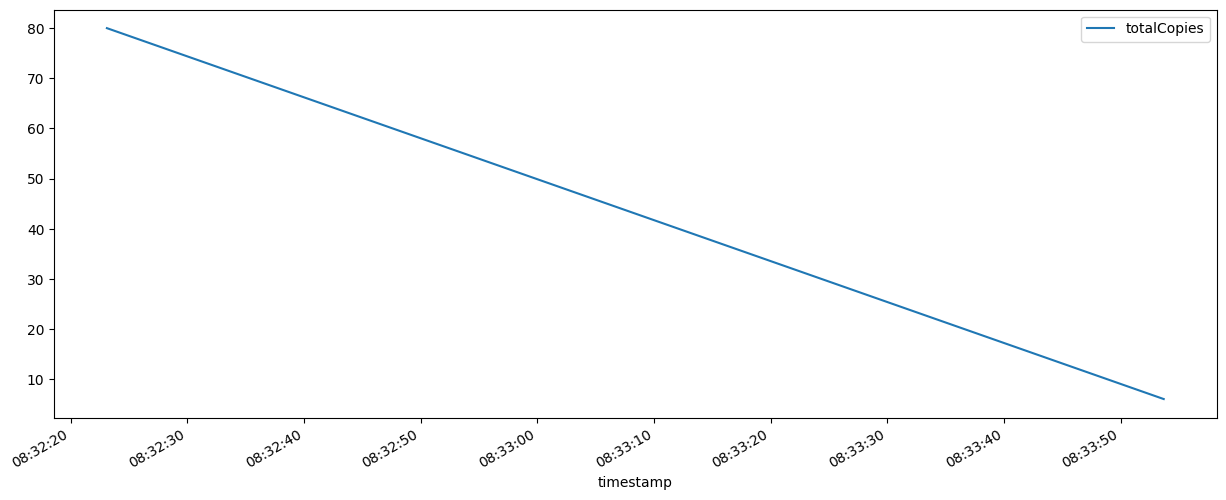

In [54]:
data = pd.read_csv(filepath)
df = pd.DataFrame(data, columns = ['timestamp', 'totalCopies'])

# Set the Date as Index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.index = df['timestamp']
del df['timestamp']

df.plot(figsize=(15, 6))
plt.show()

# 2. jobs.csv